## Memory Implementation 
We can user it as Resume conversation or new conversation page by assisgning different thread id's
-> Short term memory
-> Fault tolerance
-> Human in the loop
-> Time travel

In [51]:
# Importing the module
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import InMemorySaver #Saves in RAM
from typing import TypedDict
from dotenv import load_dotenv

In [52]:
load_dotenv()
llm = ChatGroq(model="llama-3.1-8b-instant", temperature=0)

In [53]:
# Creating a state
class JokeState(TypedDict):
    topic: str
    joke: str
    explanation : str

In [54]:
# Function of joke
def gen_joke(state: JokeState):
    prompt = f" Generate a funny joke from the topic {state["topic"]}"
    response = llm.invoke(prompt)
    return {"joke": response}

def gen_explanation(state: JokeState):
    prompt = f"{state["joke"]} This is a joke, I want you to explain it."
    response = llm.invoke(prompt)
    return {"explanation": response}

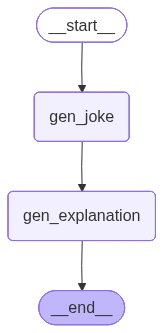

In [55]:
# Creating a graph
graph = StateGraph(JokeState)

# Creating nodes
graph.add_node('gen_joke', gen_joke)
graph.add_node('gen_explanation', gen_explanation)

# creating edges
graph.add_edge(START, 'gen_joke')
graph.add_edge('gen_joke', 'gen_explanation')
graph.add_edge('gen_explanation', END)

# Creating thing for memory
checkpointer = InMemorySaver()
# Compiling with memory
workflow = graph.compile(checkpointer)
workflow

In [66]:
# Executing workflow
thread_id = '1'
config = {'configurable': {'thread_id': thread_id}}
workflow.invoke({"topic":"pizza"}, config=config)

{'topic': 'pizza',
 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.024511529, 'prompt_time': 0.006120282, 'queue_time': 0.050858448, 'total_time': 0.030631811}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--28f460da-1e3a-4b29-9fd0-f92d97bc881e-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}),
 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and had a lot of topping

In [67]:
# Can get state of our workflow
workflow.get_state(config)

StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.024511529, 'prompt_time': 0.006120282, 'queue_time': 0.050858448, 'total_time': 0.030631811}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--28f460da-1e3a-4b29-9fd0-f92d97bc881e-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}), 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and h

In [68]:
# We can even see intermediate states as well
list(workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.024511529, 'prompt_time': 0.006120282, 'queue_time': 0.050858448, 'total_time': 0.030631811}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--28f460da-1e3a-4b29-9fd0-f92d97bc881e-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}), 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and 

In [69]:
# MAking config2 
config2 = {'configurable': {'thread_id': '2'}}
workflow.invoke({'topic':'pasta'}, config = config2)

{'topic': 'pasta',
 'joke': AIMessage(content='Why did the spaghetti go to therapy? \n\nBecause it was feeling a little "twisted" and had a lot of "noodle" issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 43, 'total_tokens': 74, 'completion_time': 0.018519754, 'prompt_time': 0.010411474, 'queue_time': 0.045779526, 'total_time': 0.028931228}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c8fb5bd-0916-4345-b9c6-e488809e76ad-0', usage_metadata={'input_tokens': 43, 'output_tokens': 31, 'total_tokens': 74}),
 'explanation': AIMessage(content='This is a joke about a spaghetti going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the spaghetti go to therapy?" This is a common joke format where the punchline is a play on words or a clever twist on the situation.\n- The punchline is "Because it was f

In [70]:
# For thread id 2, state will also save but differently not in pizza one
workflow.get_state(config2)

StateSnapshot(values={'topic': 'pasta', 'joke': AIMessage(content='Why did the spaghetti go to therapy? \n\nBecause it was feeling a little "twisted" and had a lot of "noodle" issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 43, 'total_tokens': 74, 'completion_time': 0.018519754, 'prompt_time': 0.010411474, 'queue_time': 0.045779526, 'total_time': 0.028931228}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c8fb5bd-0916-4345-b9c6-e488809e76ad-0', usage_metadata={'input_tokens': 43, 'output_tokens': 31, 'total_tokens': 74}), 'explanation': AIMessage(content='This is a joke about a spaghetti going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the spaghetti go to therapy?" This is a common joke format where the punchline is a play on words or a clever twist on the situation.\n- The punchline i

In [71]:
# Thread_id basically seems as different classes
workflow.get_state(config)

StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.024511529, 'prompt_time': 0.006120282, 'queue_time': 0.050858448, 'total_time': 0.030631811}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--28f460da-1e3a-4b29-9fd0-f92d97bc881e-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}), 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and h

In [72]:
# Intermediate values of config2
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'pasta', 'joke': AIMessage(content='Why did the spaghetti go to therapy? \n\nBecause it was feeling a little "twisted" and had a lot of "noodle" issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 43, 'total_tokens': 74, 'completion_time': 0.018519754, 'prompt_time': 0.010411474, 'queue_time': 0.045779526, 'total_time': 0.028931228}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4c8fb5bd-0916-4345-b9c6-e488809e76ad-0', usage_metadata={'input_tokens': 43, 'output_tokens': 31, 'total_tokens': 74}), 'explanation': AIMessage(content='This is a joke about a spaghetti going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the spaghetti go to therapy?" This is a common joke format where the punchline is a play on words or a clever twist on the situation.\n- The punchline 

In [73]:
#  Intermediate values of config2
list(workflow.get_state_history(config))

[StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.024511529, 'prompt_time': 0.006120282, 'queue_time': 0.050858448, 'total_time': 0.030631811}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--28f460da-1e3a-4b29-9fd0-f92d97bc881e-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}), 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and 

## Time Travel
Here we can reach to any intermediate state by using their checkpoint id. Suppose we want 

In [75]:
workflow.get_state({'configurable':{'thread_id': '1', 'checkpoint_id': '1f08c03a-5bda-6c48-8000-ad51063f0f3e'}})

StateSnapshot(values={'topic': 'pizza'}, next=('gen_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f08c03a-5bda-6c48-8000-ad51063f0f3e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-07T15:59:34.194695+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08c03a-5bd8-6523-bfff-770b0e2b9395'}}, tasks=(PregelTask(id='c01439c1-f48f-adff-8e1b-e4f6bb2fa826', name='gen_joke', path=('__pregel_pull', 'gen_joke'), error=None, interrupts=(), state=None, result={'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.026466575, 'prompt_time': 0.007761658, 'queue_time': 0.045143412, 'total_time': 0.034228233}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7083106d2c', 

In [76]:
# Invoking the workflow from the state where we just had the topic
workflow.invoke(None, {'configurable':{'thread_id': '1', 'checkpoint_id': '1f08c03a-5bda-6c48-8000-ad51063f0f3e' }} )

{'topic': 'pizza',
 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.031799611, 'prompt_time': 0.006568865, 'queue_time': 0.048877335, 'total_time': 0.038368476}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--104ed24b-1238-4193-a780-59466bdf0f07-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}),
 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and had a lot of topping

In [77]:
list(workflow.get_state_history(config=config))

[StateSnapshot(values={'topic': 'pizza', 'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.031799611, 'prompt_time': 0.006568865, 'queue_time': 0.048877335, 'total_time': 0.038368476}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c40956ddc4', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--104ed24b-1238-4193-a780-59466bdf0f07-0', usage_metadata={'input_tokens': 43, 'output_tokens': 24, 'total_tokens': 67}), 'explanation': AIMessage(content='This is a joke about a pizza going to therapy. Here\'s a breakdown of the joke:\n\n- The setup is "Why did the pizza go to therapy?" This is a common joke format where the punchline is a play on words or a unexpected twist.\n- The punchline is "Because it was feeling crusty and 

In [ ]:
workflow.get_state({'configurable':{'thread_id': '1', 'checkpoint_id': '1f08c03a-5bda-6c48-8000-ad51063f0f3e'}})

(StateSnapshot(values={'topic': 'pizza'}, next=('gen_joke',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f08c03a-5bda-6c48-8000-ad51063f0f3e'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-07T15:59:34.194695+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08c03a-5bd8-6523-bfff-770b0e2b9395'}}, tasks=(PregelTask(id='c01439c1-f48f-adff-8e1b-e4f6bb2fa826', name='gen_joke', path=('__pregel_pull', 'gen_joke'), error=None, interrupts=(), state=None, result={'joke': AIMessage(content='Why did the pizza go to therapy? \n\nBecause it was feeling crusty and had a lot of topping issues.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 43, 'total_tokens': 67, 'completion_time': 0.026466575, 'prompt_time': 0.007761658, 'queue_time': 0.045143412, 'total_time': 0.034228233}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_7083106d2c',